# Set Parameter
- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Drop out = 0.2
- Hidden unit = [2, 50]
- Depth = [1, 32]
- Epochs = 100
- N = 100
- Data = 100K
- Deduplication

# Import packages

import useful packages for experiments

In [2]:
import os
import argparse
import logging
import sys

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))

from trainer.supervised_trainer_without_eval import SupervisedTrainer_without_eval
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.evaluator import Evaluator

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [3]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

# Data load

In [4]:
train_path = "../../data/bracket_dedup/K100/data_train.txt"

# Prepare dataset

In [5]:
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Prepare loss

In [6]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Variable definition

In [7]:
optimizer = "Adam"
hidden_sizes = list(range(2, 51, 2))
depth_list = []
bidirectional = True
print(hidden_sizes)
evaluator = Evaluator(loss=loss, batch_size=32)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]


In [10]:
for i in hidden_sizes:
    hidden_size = i
    print("hidden size is : %d" % hidden_size)
    seq2seq = None
    encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                         bidirectional=bidirectional, variable_lengths=True)
    decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                         dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                         eos_id=tgt.eos_id, sos_id=tgt.sos_id)
    seq2seq = Seq2seq(encoder, decoder)
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)
    
    depths = list(range(32, 0, -1))
    print(depths)
    for depth in depths:
        log_path = "../../log/pth/bracket_dedup_K100_hidden_" + str(hidden_size) + "_model_save.pth"
        seq2seq.load_state_dict(torch.load(log_path))
        seq2seq.eval()
        dev_path = "../../data/bracket_dedup/K100/dev_depth/data_test_depth_" + str(depth) + ".txt"
        dev = torchtext.data.TabularDataset(
              path=dev_path, format='tsv',
              fields=[('src', src), ('tgt', tgt)],
              filter_pred=len_filter)
        dev_loss, character_accuracy, sentence_accuracy = evaluator.evaluate(seq2seq, dev)
        print("Depth:%d, Dev Loss:%0.4f, Character Accuracy:%0.4f, Sentence Accuracy:%0.4f\n"
                    % (depth, dev_loss, character_accuracy, sentence_accuracy))
        check_path = "../../log/check_point/bracket_dedup_hidden_size_to_depth_sentence/hidden_size_" + str(hidden_size)
        with open(check_path, 'a') as f:
            f.write("Depth:%d, Dev Loss:%0.4f, Character Accuracy:%0.4f, Sentence Accuracy:%0.4f\n"
                    % (depth, dev_loss, character_accuracy, sentence_accuracy))
        
        if sentence_accuracy >= 0.95:
            depth_list.append(depth)
            break
        if depth == 1:
            depth_list.append(depth)

hidden size is : 2
[32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Depth:32, Dev Loss:79.4578, Character Accuracy:0.1158, Sentence Accuracy:0.0000

Depth:31, Dev Loss:404.5832, Character Accuracy:0.1989, Sentence Accuracy:0.0000

Depth:30, Dev Loss:38.8016, Character Accuracy:0.1348, Sentence Accuracy:0.0000

Depth:29, Dev Loss:30.7182, Character Accuracy:0.1441, Sentence Accuracy:0.0000

Depth:28, Dev Loss:38.0933, Character Accuracy:0.1485, Sentence Accuracy:0.0000

Depth:27, Dev Loss:38.9572, Character Accuracy:0.1490, Sentence Accuracy:0.0000

Depth:26, Dev Loss:45.2359, Character Accuracy:0.1433, Sentence Accuracy:0.0000

Depth:25, Dev Loss:75.7678, Character Accuracy:0.1563, Sentence Accuracy:0.0000

Depth:24, Dev Loss:143.3564, Character Accuracy:0.1605, Sentence Accuracy:0.0000

Depth:23, Dev Loss:189.7524, Character Accuracy:0.1667, Sentence Accuracy:0.0000

Depth:22, Dev Loss:186.1620, Character Accuracy:

Depth:31, Dev Loss:12.1758, Character Accuracy:0.4731, Sentence Accuracy:0.0000

Depth:30, Dev Loss:9.7805, Character Accuracy:0.4044, Sentence Accuracy:0.0000

Depth:29, Dev Loss:5.3726, Character Accuracy:0.4625, Sentence Accuracy:0.0000

Depth:28, Dev Loss:5.8392, Character Accuracy:0.4731, Sentence Accuracy:0.0000

Depth:27, Dev Loss:4.6131, Character Accuracy:0.4807, Sentence Accuracy:0.0000

Depth:26, Dev Loss:3.8780, Character Accuracy:0.5071, Sentence Accuracy:0.0000

Depth:25, Dev Loss:3.7168, Character Accuracy:0.5061, Sentence Accuracy:0.0000

Depth:24, Dev Loss:3.6572, Character Accuracy:0.5124, Sentence Accuracy:0.0000

Depth:23, Dev Loss:3.5178, Character Accuracy:0.5130, Sentence Accuracy:0.0000

Depth:22, Dev Loss:3.7364, Character Accuracy:0.5060, Sentence Accuracy:0.0000

Depth:21, Dev Loss:3.7905, Character Accuracy:0.5063, Sentence Accuracy:0.0000

Depth:20, Dev Loss:3.6838, Character Accuracy:0.5132, Sentence Accuracy:0.0000

Depth:19, Dev Loss:3.6072, Character Ac

Depth:27, Dev Loss:2.2716, Character Accuracy:0.6472, Sentence Accuracy:0.0000

Depth:26, Dev Loss:2.2693, Character Accuracy:0.6431, Sentence Accuracy:0.0000

Depth:25, Dev Loss:2.2305, Character Accuracy:0.6534, Sentence Accuracy:0.0000

Depth:24, Dev Loss:2.1809, Character Accuracy:0.6582, Sentence Accuracy:0.0000

Depth:23, Dev Loss:2.1400, Character Accuracy:0.6661, Sentence Accuracy:0.0000

Depth:22, Dev Loss:2.1129, Character Accuracy:0.6730, Sentence Accuracy:0.0000

Depth:21, Dev Loss:2.1142, Character Accuracy:0.6732, Sentence Accuracy:0.0000

Depth:20, Dev Loss:2.0772, Character Accuracy:0.6821, Sentence Accuracy:0.0000

Depth:19, Dev Loss:2.0555, Character Accuracy:0.6873, Sentence Accuracy:0.0000

Depth:18, Dev Loss:2.0175, Character Accuracy:0.6952, Sentence Accuracy:0.0000

Depth:17, Dev Loss:2.0025, Character Accuracy:0.6998, Sentence Accuracy:0.0000

Depth:16, Dev Loss:1.9936, Character Accuracy:0.7028, Sentence Accuracy:0.0000

Depth:15, Dev Loss:1.9765, Character Acc

Depth:22, Dev Loss:1.0214, Character Accuracy:0.9934, Sentence Accuracy:0.6797

Depth:21, Dev Loss:1.0188, Character Accuracy:0.9937, Sentence Accuracy:0.6921

Depth:20, Dev Loss:1.0160, Character Accuracy:0.9946, Sentence Accuracy:0.7375

Depth:19, Dev Loss:1.0143, Character Accuracy:0.9951, Sentence Accuracy:0.7627

Depth:18, Dev Loss:1.0119, Character Accuracy:0.9959, Sentence Accuracy:0.8173

Depth:17, Dev Loss:1.0099, Character Accuracy:0.9965, Sentence Accuracy:0.8465

Depth:16, Dev Loss:1.0097, Character Accuracy:0.9966, Sentence Accuracy:0.8546

Depth:15, Dev Loss:1.0066, Character Accuracy:0.9976, Sentence Accuracy:0.8942

Depth:14, Dev Loss:1.0062, Character Accuracy:0.9979, Sentence Accuracy:0.9120

Depth:13, Dev Loss:1.0053, Character Accuracy:0.9982, Sentence Accuracy:0.9301

Depth:12, Dev Loss:1.0044, Character Accuracy:0.9986, Sentence Accuracy:0.9552

hidden size is : 22
[32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7

Depth:31, Dev Loss:1.6606, Character Accuracy:0.8548, Sentence Accuracy:0.0000

Depth:30, Dev Loss:1.7683, Character Accuracy:0.8174, Sentence Accuracy:0.0000

Depth:29, Dev Loss:1.4754, Character Accuracy:0.8895, Sentence Accuracy:0.0000

Depth:28, Dev Loss:1.2572, Character Accuracy:0.9477, Sentence Accuracy:0.0000

Depth:27, Dev Loss:1.0743, Character Accuracy:0.9755, Sentence Accuracy:0.2179

Depth:26, Dev Loss:1.0542, Character Accuracy:0.9817, Sentence Accuracy:0.5075

Depth:25, Dev Loss:1.0270, Character Accuracy:0.9905, Sentence Accuracy:0.6872

Depth:24, Dev Loss:1.0114, Character Accuracy:0.9967, Sentence Accuracy:0.8385

Depth:23, Dev Loss:1.0053, Character Accuracy:0.9986, Sentence Accuracy:0.9355

Depth:22, Dev Loss:1.0010, Character Accuracy:0.9998, Sentence Accuracy:0.9847

hidden size is : 32
[32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
Depth:32, Dev Loss:2.1458, Character Accuracy:0.8158, Senten

In [14]:
depth_list = [1, 1, 1, 1, 2, 1, 1, 1, 4, 12, 15, 1, 10, 23, 22, 24, 25, 27, 19, 23, 32, 31, 29, 29, 31]

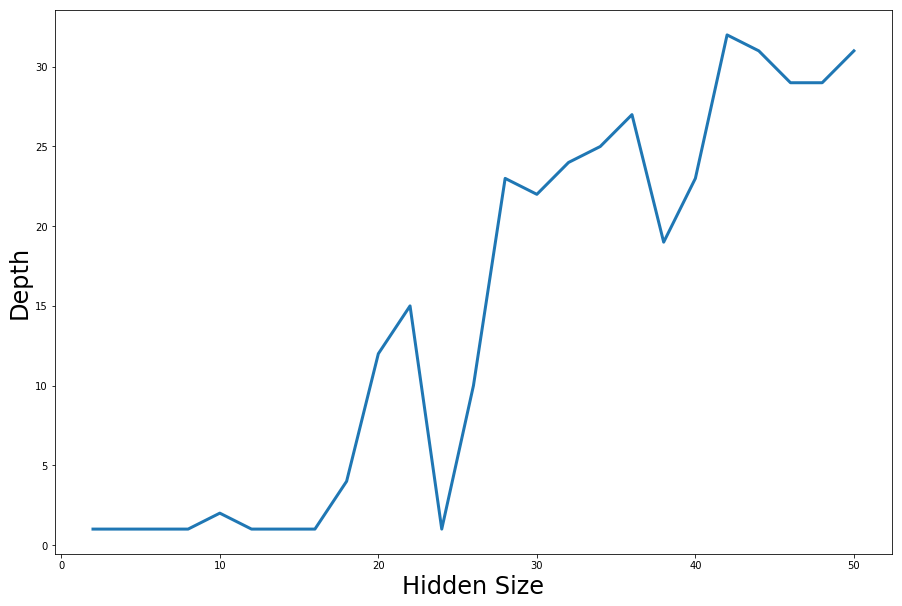

In [15]:
plt.figure(figsize=(15,10))
plt.plot(hidden_sizes, depth_list, LineWidth=3)
plt.xlabel('Hidden Size', fontsize=24)
plt.ylabel('Depth', fontsize=24)
plt.savefig('../../log/plot/bracket_dedup_hidden_size_to_depth_sentence/bracket_dedup_hidden_size_to_depth.png')

In [16]:
print(hidden_sizes)
print(depth_list)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
[1, 1, 1, 1, 2, 1, 1, 1, 4, 12, 15, 1, 10, 23, 22, 24, 25, 27, 19, 23, 32, 31, 29, 29, 31]
